## Indicator Strategy Exploration — y_logret_168h_huber

Purpose: load model predictions and artifacts from the BINANCE_BTCUSDT.P, 60 run to support indicator-based strategy evaluation (similar to `strategies/inspect_y_logret_performance.ipynb`).

Data sources in `.../diagnosis/y_logret_168h_huber`:
- **pred_train.csv / pred_val.csv / pred_test.csv**: `timestamp`, `y_true` (target `y_logret_24h`), `y_pred` (model prediction)
- **metrics.json**: RMSE per split
- **best_params.json**: tuned LightGBM parameters
- **pipeline_config.json**: input paths, target specification, splits, tuning config
- **feature_importance.csv**: feature importance (gain, split)
- **tuning_trials.csv / model.txt / run_metadata.json / prep_metadata.json / paths.json**: supplementary artifacts

We'll load and lightly inspect these to prepare for indicator strategy experiments.


In [8]:
from __future__ import annotations
import json
from pathlib import Path

import pandas as pd

# Paths
DIAG_DIR = Path("/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_hmm")

PRED_TRAIN = DIAG_DIR / "pred_train.csv"
PRED_VAL = DIAG_DIR / "pred_val.csv"
PRED_TEST = DIAG_DIR / "pred_test.csv"

METRICS_JSON = DIAG_DIR / "metrics.json"
BEST_PARAMS_JSON = DIAG_DIR / "best_params.json"
PIPELINE_CONFIG_JSON = DIAG_DIR / "pipeline_config.json"
FEATURE_IMPORTANCE_CSV = DIAG_DIR / "feature_importance.csv"

PD_READ_CSV_KW = dict(parse_dates=["timestamp"], infer_datetime_format=True)

DIAG_DIR, PRED_TRAIN.exists(), PRED_VAL.exists(), PRED_TEST.exists()


(PosixPath('/Volumes/Extreme SSD/trading_data/cex/models/BINANCE_BTCUSDT.P, 60/diagnosis/y_logret_24h_hmm'),
 True,
 True,
 True)

In [9]:
# Load metrics and key configs
with METRICS_JSON.open() as f:
    metrics = json.load(f)
with BEST_PARAMS_JSON.open() as f:
    best_params = json.load(f)
with PIPELINE_CONFIG_JSON.open() as f:
    pipeline_config = json.load(f)

metrics, list(best_params.items())[:5], pipeline_config["target"], pipeline_config["split"]


({'rmse_train': 0.023575664844220412,
  'rmse_val': 0.027354268042071198,
  'rmse_test': 0.01890926205193744},
 [('learning_rate', 0.02),
  ('num_leaves', 255),
  ('max_depth', -1),
  ('min_data_in_leaf', 25),
  ('feature_fraction', 0.6)],
 {'variable': 'y_logret_24h', 'objective': {'name': 'huber', 'params': {}}},
 {'train_ratio': 0.7, 'val_ratio': 0.15, 'test_ratio': 0.15})

In [ ]:
# Load prediction CSVs
pred_train = pd.read_csv(PRED_TRAIN, **PD_READ_CSV_KW)
pred_val = pd.read_csv(PRED_VAL, **PD_READ_CSV_KW)
pred_test = pd.read_csv(PRED_TEST, **PD_READ_CSV_KW)

pred_test_original = pred_test.copy()
pred_test = pred_test[pred_test['timestamp'] <= pd.to_datetime('2025-07-23 20:00:00')]

for name, df in ("train", pred_train), ("val", pred_val), ("test", pred_test):
    print(name, df.shape, df.columns.tolist(), df.timestamp.min(), df.timestamp.max())

# Quick sanity checks
assert set(pred_train.columns) == {"timestamp", "y_true", "y_pred"}
assert set(pred_val.columns) == {"timestamp", "y_true", "y_pred"}
assert set(pred_test.columns) == {"timestamp", "y_true", "y_pred"}

# Concatenate with split label for unified analysis later
pred_train["split"] = "train"
pred_val["split"] = "val"
pred_test["split"] = "test"

for df in (pred_train, pred_val, pred_test):
    #df["ind_pred_pos"] = np.sign(pd.to_numeric(df["y_pred"], errors="coerce")).astype(int) # long and short
    df["ind_pred_pos"] = (df["y_pred"] > 0.002).astype(int) # long only
pred_all = pd.concat([pred_train, pred_val, pred_test], ignore_index=True)
pred_all.sort_values("timestamp", inplace=True)
pred_all.head(3), pred_all.tail(3)


train (15521, 3) ['timestamp', 'y_true', 'y_pred'] 2023-01-31 00:00:00 2024-11-07 16:00:00
val (3325, 3) ['timestamp', 'y_true', 'y_pred'] 2024-11-07 17:00:00 2025-03-26 05:00:00
test (2871, 3) ['timestamp', 'y_true', 'y_pred'] 2025-03-26 06:00:00 2025-07-23 20:00:00


/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_71745/375967270.py:2: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pred_train = pd.read_csv(PRED_TRAIN, **PD_READ_CSV_KW)
/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_71745/375967270.py:3: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  pred_val = pd.read_csv(PRED_VAL, **PD_READ_CSV_KW)
/var/folders/my/18kmg51d1lz3l9rnds2gkf1r0000gn/T/ipykernel_71745/375967270.py:4: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict v

(            timestamp    y_true    y_pred  split  ind_pred_pos
 0 2023-01-31 00:00:00  0.010941  0.002457  train             0
 1 2023-01-31 01:00:00  0.012641  0.002457  train             0
 2 2023-01-31 02:00:00  0.010933  0.002457  train             0,
                 timestamp    y_true    y_pred split  ind_pred_pos
 21714 2025-07-23 18:00:00  0.005639  0.002689  test             0
 21715 2025-07-23 19:00:00  0.004701  0.002689  test             0
 21716 2025-07-23 20:00:00  0.006931  0.003065  test             0)

In [5]:
def _load_ohlcv(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    # Prefer 'timestamp' if present, else 'time'
    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True)
    elif 'time' in df.columns:
        ts = pd.to_datetime(df['time'], errors='coerce', utc=True)
    else:
        raise ValueError("OHLCV CSV must have 'timestamp' or 'time' column")
    df['timestamp'] = ts.dt.tz_convert('UTC').dt.tz_localize(None)
    # Normalize column names
    colmap = {}
    for c in df.columns:
        lc = str(c).lower()
        if lc in {'open', 'high', 'low', 'close'}:
            colmap[c] = lc
    df = df.rename(columns=colmap)
    required = {'open', 'high', 'low', 'close', 'timestamp'}
    if not required.issubset(df.columns):
        missing = required - set(df.columns)
        raise ValueError(f"OHLCV CSV missing columns: {sorted(missing)}")
    return df[['timestamp', 'open', 'high', 'low', 'close']].dropna(subset=['timestamp'])

ohlcv = _load_ohlcv("/Users/noel/projects/trading_cex/data/BINANCE_BTCUSDT.P, 60.csv")

In [11]:
# Optional: load feature importances
try:
    fi = pd.read_csv(FEATURE_IMPORTANCE_CSV)
    fi.sort_values("importance_gain", ascending=False, inplace=True)
    print(fi.head(10))
except FileNotFoundError:
    print("feature_importance.csv not found")


                            feature  importance_gain  importance_split
0      close_ma_cross_diff_5_20_12H         0.330232                 8
1         close_percentile_50_20_4H         0.306186                 3
2                   close_wma_20_1D         0.298373                 4
3                   close_adx_14_1D         0.281699                 8
4                  close_sma_20_12H         0.279547                 5
5          close_rolling_max_20_12H         0.273855                 1
6           close_bb_upper_20_2_12H         0.238755                 5
7              close_entropy_20_12H         0.235948                14
8  close_macd_histogram_12_26_9_12H         0.231738                 7
9                  close_adx_14_12H         0.217757                13


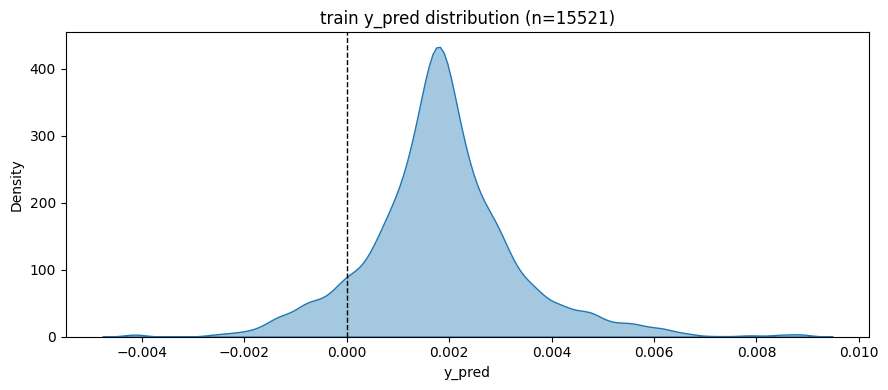

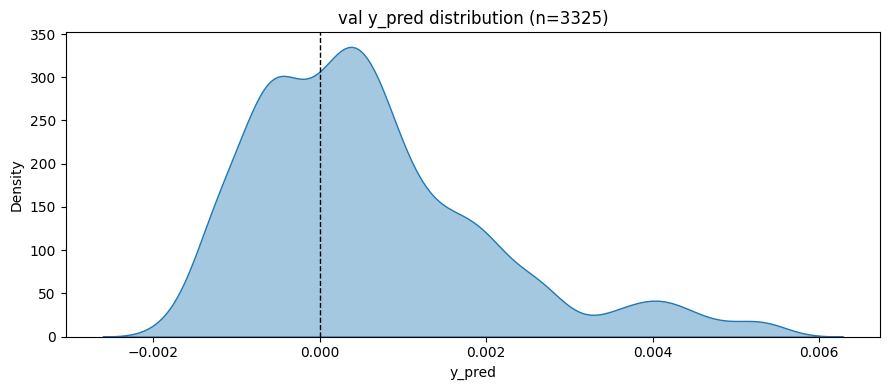

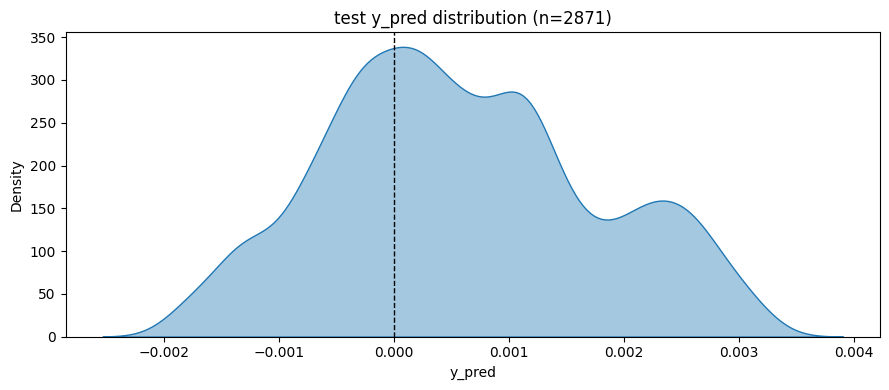

In [12]:
# Separate figures: one distribution plot per split (y_pred)
import matplotlib.pyplot as plt

try:
    import seaborn as sns  # type: ignore
except Exception:
    sns = None

splits = ["train", "val", "test"]

# Keep consistent x-limits across panels for comparability
q_low = float(pred_all["y_pred"].quantile(0.01))
q_high = float(pred_all["y_pred"].quantile(0.99))

for split_name in splits:
    df_split = pred_all[pred_all["split"] == split_name]
    fig, ax = plt.subplots(figsize=(9, 4))
    if sns is not None:
        sns.kdeplot(data=df_split, x="y_pred", fill=True, alpha=0.4, ax=ax)
    else:
        ax.hist(df_split["y_pred"].clip(q_low, q_high), bins=100, density=True, alpha=0.6)
    ax.axvline(0.0, color="k", linestyle="--", linewidth=1)
    ax.set_title(f"{split_name} y_pred distribution (n={len(df_split)})")
    ax.set_xlabel("y_pred")
    ax.set_ylabel("Density")
    plt.tight_layout()
    plt.show()


In [17]:
import numpy as np
import pandas as pd

def evaluate_trades(df: pd.DataFrame, signal_col: str, name: str = "trades"):
    # signal_col should be -1/0/1 (e.g., long/flat/short). 1/0 works for long-only.
    s = pd.to_numeric(df[signal_col], errors='coerce').fillna(0).astype(int)
    y_log = pd.to_numeric(df['y_true'], errors='coerce')

    trades = (s != 0)
    num_trades = int(trades.sum())
    wins = (np.sign(y_log[trades]) == s[trades]) & (np.sign(y_log[trades]) != 0)
    win_rate = float(wins.mean()) if num_trades > 0 else float('nan')

    # Per-row simple return; long = exp(y)-1, short = -(exp(y)-1)
    simple_ret = np.exp(y_log) - 1.0
    pnl_pct = (s * simple_ret) * 100.0

    cumulative_pct = float(pnl_pct.sum())

    if 'timestamp' in df.columns:
        ts = pd.to_datetime(df['timestamp'], errors='coerce', utc=True).dt.tz_convert('UTC').dt.tz_localize(None)
        cum_series = pnl_pct.set_axis(ts).cumsum()
    else:
        cum_series = pnl_pct.cumsum()

    print(f"{name}: trades={num_trades}, win_rate={win_rate:.3f}, cumulative_pct={cumulative_pct:.6f}")
    return cum_series

In [20]:
evaluate_trades(pred_train, signal_col="ind_pred_pos", name="train")
evaluate_trades(pred_val, signal_col="ind_pred_pos", name="val")
evaluate_trades(pred_test, signal_col="ind_pred_pos", name="test")

train: trades=8458, win_rate=0.895, cumulative_pct=48424.934395
val: trades=1009, win_rate=0.663, cumulative_pct=3185.545693
test: trades=682, win_rate=0.890, cumulative_pct=2737.602231


timestamp
2025-03-10 02:00:00       1.234186
2025-03-10 03:00:00       3.235281
2025-03-10 04:00:00       4.450745
2025-03-10 05:00:00       5.436919
2025-03-10 06:00:00       6.516419
                          ...     
2025-07-23 16:00:00    2737.602231
2025-07-23 17:00:00    2737.602231
2025-07-23 18:00:00    2737.602231
2025-07-23 19:00:00    2737.602231
2025-07-23 20:00:00    2737.602231
Length: 3259, dtype: float64

In [15]:
pred_test

,timestamp,y_true,y_pred,split,ind_pred_pos
0,2025-03-10 02:00:00,0.012266,0.018645,test,1
1,2025-03-10 03:00:00,0.019813,0.018645,test,1
2,2025-03-10 04:00:00,0.012081,0.018645,test,1
3,2025-03-10 05:00:00,0.009813,0.018645,test,1
4,2025-03-10 06:00:00,0.010737,0.018645,test,1
...,...,...,...,...,...
3254,2025-07-23 16:00:00,0.000219,-0.016441,test,0
3255,2025-07-23 17:00:00,-0.002805,-0.000310,test,0
3256,2025-07-23 18:00:00,-0.015824,-0.000310,test,0
3257,2025-07-23 19:00:00,-0.012578,-0.000310,test,0


In [13]:
# Correlation between y_true and y_pred (Pearson)
import pandas as pd

corr = lambda a, b: pd.to_numeric(a, errors='coerce').corr(pd.to_numeric(b, errors='coerce'))

corr_train = corr(pred_train['y_true'], pred_train['y_pred'])
corr_val = corr(pred_val['y_true'], pred_val['y_pred'])
corr_test = corr(pred_test['y_true'], pred_test['y_pred'])

mask = pred_all['split'].isin(['test', 'val'])
corr_all = corr(pred_all.loc[mask, 'y_true'], pred_all.loc[mask, 'y_pred'])

print(f"train corr: {corr_train:.6f}")
print(f"val   corr: {corr_val:.6f}")
print(f"test  corr: {corr_test:.6f}")
print(f"val+test   corr: {corr_all:.6f}")


train corr: 0.910030
val   corr: 0.064517
test  corr: 0.005955
val+test   corr: 0.044768


In [132]:
def plot_y_true_colored_segments(
    df,
    ts_col: str = "timestamp",
    y_col: str = "y_true",
    signal_col: str = "ind_pred_pos",
    figsize=(14, 4),
    title: str | None = None,
    show_base: bool = True,
    base_color: str = "#bbbbbb",
    base_alpha: float = 0.5,
    base_lw: float = 1.2,
    long_color: str = "#2ca02c",
    short_color: str = "#d62728",
    win_style: str = "-",
    loss_style: str = "--",
    line_width: float = 2.0,
    draw_zero_line: bool = True,
):
    """Simpler view: color y_true line segments by direction and outcome.

    - Long segments in green, short in red
    - Solid line = profitable trade, dashed = loss
    - Optional faint base line where there is no trade
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt

    if ts_col not in df.columns:
        raise KeyError(f"Column '{ts_col}' not found in DataFrame")
    if y_col not in df.columns:
        raise KeyError(f"Column '{y_col}' not found in DataFrame")
    if signal_col not in df.columns:
        raise KeyError(f"Column '{signal_col}' not found in DataFrame")

    ts = pd.to_datetime(df[ts_col], errors="coerce")
    y = pd.to_numeric(df[y_col], errors="coerce")
    s = pd.to_numeric(df[signal_col], errors="coerce").fillna(0).astype(int)

    longs = s > 0
    shorts = s < 0

    long_win = longs & (y > 0)
    long_loss = longs & (y <= 0)
    short_win = shorts & (y < 0)
    short_loss = shorts & (y >= 0)

    fig, ax = plt.subplots(figsize=figsize)

    if draw_zero_line:
        ax.axhline(0.0, color="#999999", linewidth=1.0, alpha=0.3, zorder=1)

    if show_base:
        ax.plot(ts, y.where(~(longs | shorts)), color=base_color, alpha=base_alpha, lw=base_lw, label="no trade", zorder=1)

    # Plot segments by mask with NaNs to break lines
    if long_win.any():
        ax.plot(ts, y.where(long_win), color=long_color, lw=line_width, linestyle=win_style, label="Long win", zorder=2)
    if long_loss.any():
        ax.plot(ts, y.where(long_loss), color=long_color, lw=line_width, linestyle=loss_style, label="Long loss", zorder=2)

    if short_win.any():
        ax.plot(ts, y.where(short_win), color=short_color, lw=line_width, linestyle=win_style, label="Short win", zorder=2)
    if short_loss.any():
        ax.plot(ts, y.where(short_loss), color=short_color, lw=line_width, linestyle=loss_style, label="Short loss", zorder=2)

    ax.set_xlabel("timestamp")
    ax.set_ylabel(y_col)
    if title is None:
        title = f"{y_col} colored by trade outcome"
    ax.set_title(title)
    ax.legend(loc="best")
    ax.grid(True, alpha=0.2)
    fig.autofmt_xdate()
    plt.tight_layout()
    return ax


<Axes: title={'center': '24h - Test'}, xlabel='timestamp', ylabel='y_true'>

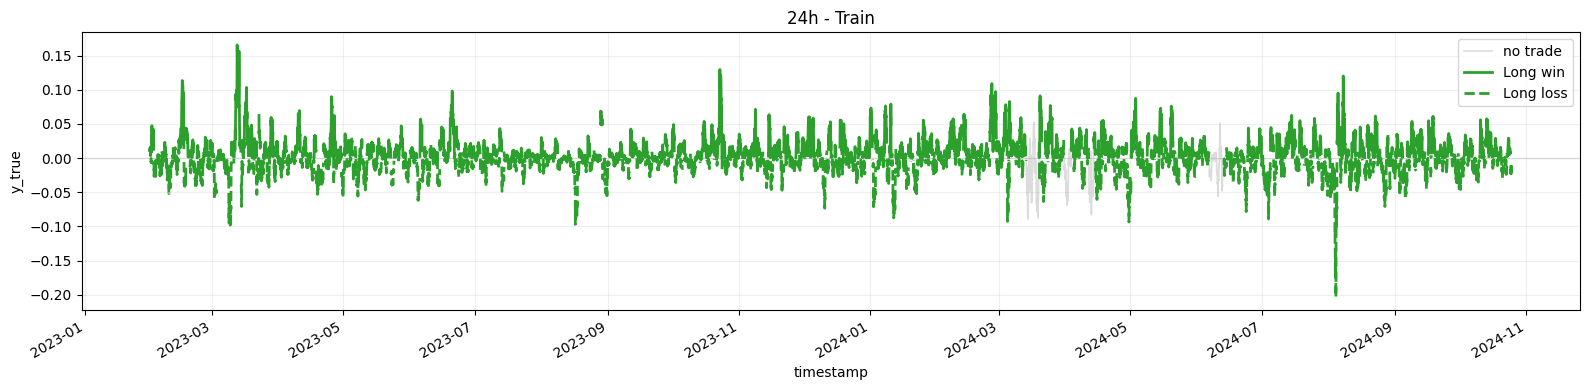

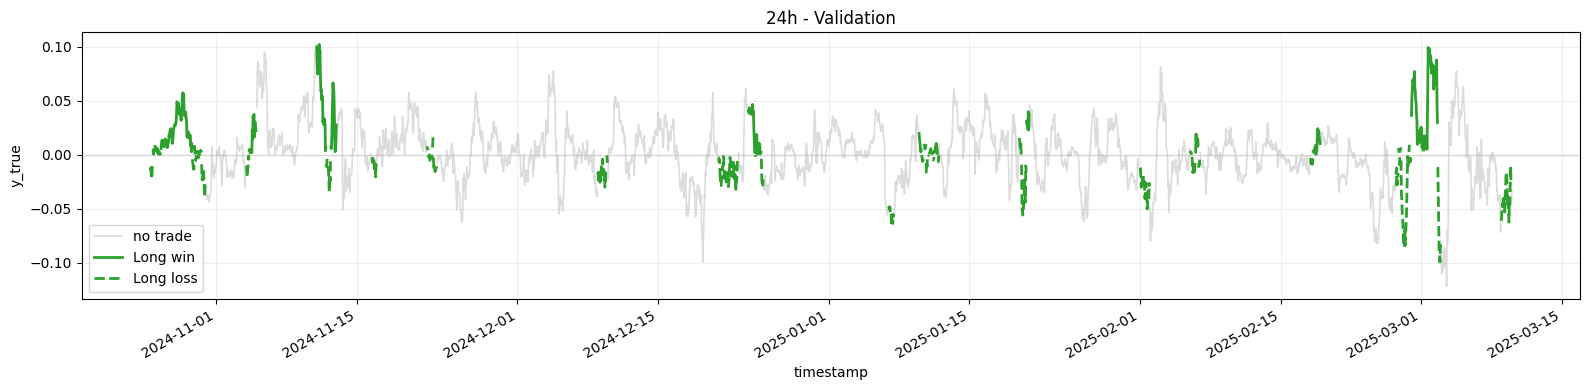

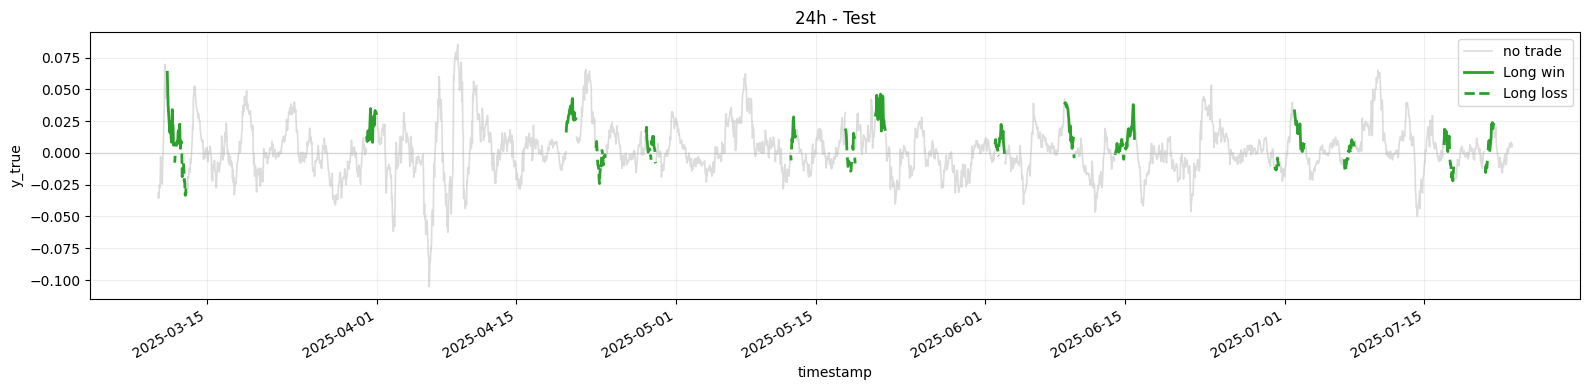

In [133]:
plot_y_true_colored_segments(pred_train, title="24h - Train", figsize=(16, 4))

plot_y_true_colored_segments(pred_val, title="24h - Validation", figsize=(16, 4))

plot_y_true_colored_segments(pred_test, title="24h - Test", figsize=(16, 4))



In [33]:
def plot_signal_ones_on_price(
    ohlcv_df,
    split_preds_df,
    ts_col: str = "timestamp",
    price_col: str = "close",
    signal_col: str = "ind_pred_pos",
    figsize=(14, 5),
    title: str | None = None,
    price_color: str = "#1f77b4",
    long_color: str = "#2ca02c",
):
    import pandas as pd
    import matplotlib.pyplot as plt

    # Hour-anchor both sides → exact merge on the bar time
    ohlcv = ohlcv_df[[ts_col, price_col]].copy()
    ohlcv[ts_col] = pd.to_datetime(ohlcv[ts_col], errors="coerce").dt.floor("h")
    ohlcv = ohlcv.dropna(subset=[ts_col]).sort_values(ts_col)
    # If duplicates per hour exist, keep last (close of hour)
    ohlcv = ohlcv.drop_duplicates(subset=[ts_col], keep="last")

    preds = split_preds_df[[ts_col, signal_col]].copy()
    preds[ts_col] = pd.to_datetime(preds[ts_col], errors="coerce").dt.floor("h")
    preds = preds.dropna(subset=[ts_col]).sort_values(ts_col)

    if preds.empty:
        raise ValueError("No valid timestamps in split_preds_df after parsing.")

    # Restrict price to split period
    start_ts, end_ts = preds[ts_col].min(), preds[ts_col].max()
    ohlcv_plot = ohlcv[(ohlcv[ts_col] >= start_ts) & (ohlcv[ts_col] <= end_ts)]

    # All bars where signal == 1
    longs_ts = preds.loc[preds[signal_col].astype(int) == 1, [ts_col]]
    longs = longs_ts.merge(ohlcv_plot, on=ts_col, how="inner")

    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(ohlcv_plot[ts_col], ohlcv_plot[price_col], color=price_color, lw=1.5, label=price_col)
    if not longs.empty:
        ax.scatter(
            longs[ts_col], longs[price_col],
            marker="^", color=long_color, edgecolor="black", linewidths=0.5, s=60,
            label="signal == 1", zorder=3
        )

    ax.set_xlim(start_ts, end_ts)
    ax.grid(True, alpha=0.2)
    ax.set_xlabel(ts_col)
    ax.set_ylabel(price_col)
    ax.set_title(title or "Price with signal==1 markers")
    ax.legend(loc="best")
    fig.autofmt_xdate()
    plt.tight_layout()
    return ax

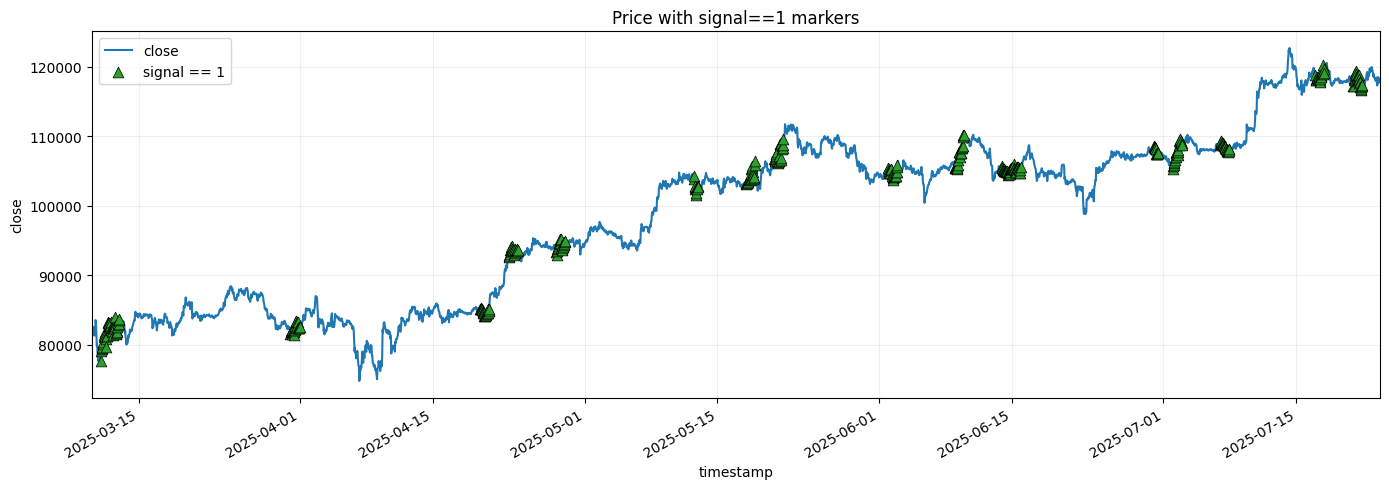

In [134]:
ax = plot_signal_ones_on_price(ohlcv, pred_test)